In [ ]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

##1. Выбрать цветное изображение (формат .jpg, .jpeg, .png) для работы и скачать его.

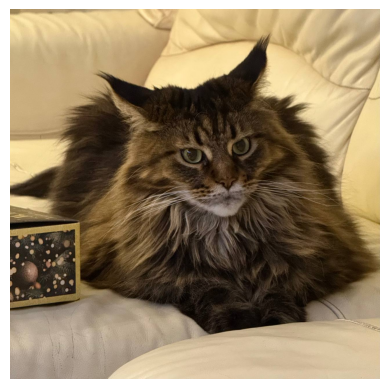

высота, ширина, каналы: (1280, 1280, 3)


In [ ]:
im_pil = Image.open('/content/umka.jpg')

plt.imshow(im_pil)
plt.axis('off')
plt.show()

im_np = np.array(im_pil)
print(f"высота, ширина, каналы: {im_np.shape}")

orig_im_np = im_np #на всякий случай сохраним ориг

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##2.Осуществить разделение изображения по цветовым каналам.

In [ ]:
#разделим на цветовые каналы

R = orig_im_np[:, :, 0]
G = orig_im_np[:, :, 1]
B = orig_im_np[:, :, 2]

##3. Изобразить все пространственные области изображения по отдельности (R, G, B) и парные комбинации (RG, GB, RB).

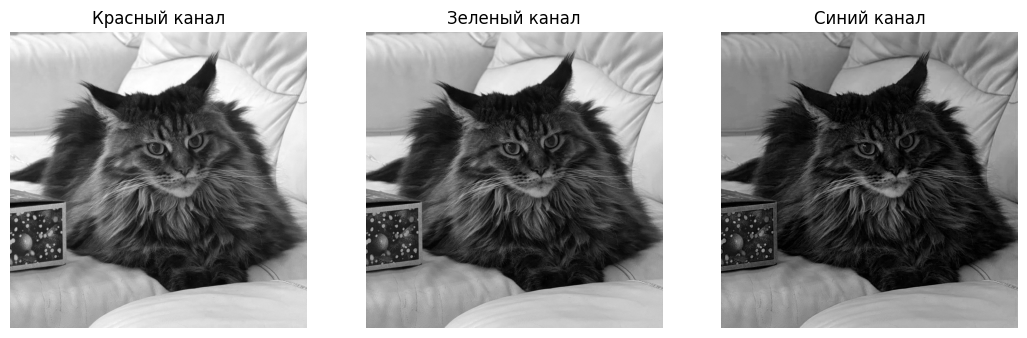

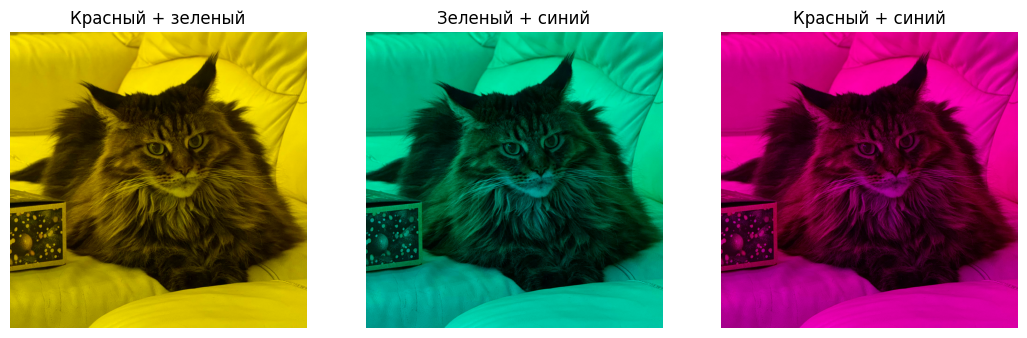

In [ ]:
#сначала отобразим по одному каналу
plt.figure(figsize=(13, 4))

plt.subplot(1, 3, 1)
plt.imshow(R, cmap='gray')
plt.title('Красный канал')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(G, cmap='gray')
plt.title('Зеленый канал')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(B, cmap='gray')
plt.title('Синий канал')
plt.axis('off')

plt.show()

#теперь комбинации
height, width, _ = orig_im_np.shape
zeros = np.zeros((height, width), dtype=orig_im_np.dtype)

#R+G
rg_image = np.stack((R, G, zeros), axis=-1)

#G+B
gb_image = np.stack((zeros, G, B), axis=-1)

#R+B
rb_image = np.stack((R, zeros, B), axis=-1)


plt.figure(figsize=(13, 4))

plt.subplot(1, 3, 1)
plt.imshow(rg_image)
plt.title('Красный + зеленый')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gb_image)
plt.title('Зеленый + синий')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(rb_image)
plt.title('Красный + синий')
plt.axis('off')

plt.show()

#4. Создать на основе данного изображение серое изображение.

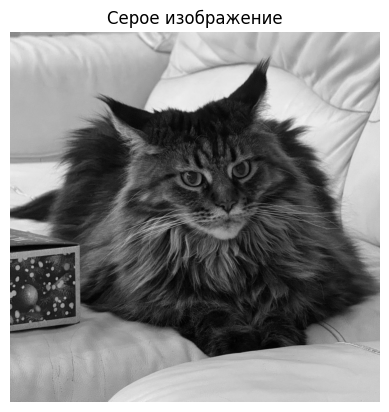

In [ ]:
gray_im_np = (0.2126*R  + 0.7152*G + 0.0722*B).astype(np.uint8)

#выведем серое изображение
plt.imshow(gray_im_np, cmap='gray')
plt.title('Серое изображение')
plt.axis('off')
plt.show()

##5. Выбрать несколько строк матрицы изображения и построить графики изменения частоты каналов (для цветного и серого изображений). Частоту для цветных изображений необходимо построить в одной системе координат.


обработка строки: 0


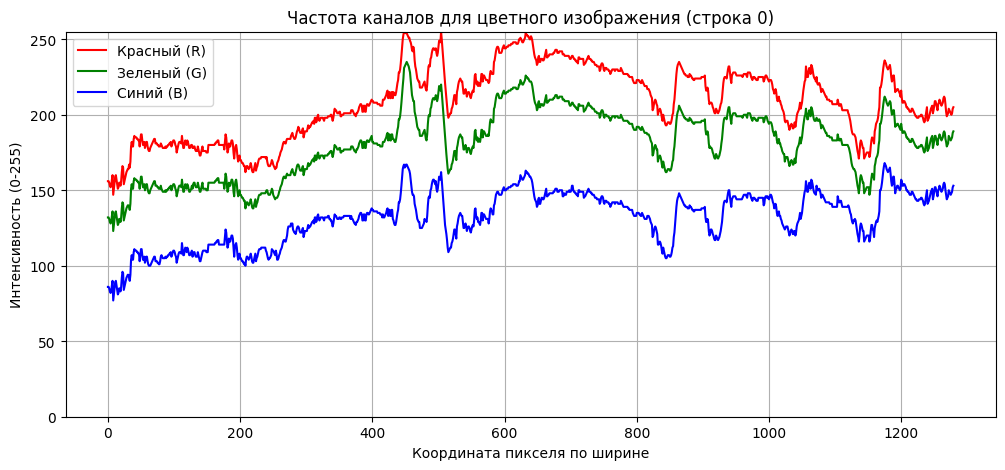

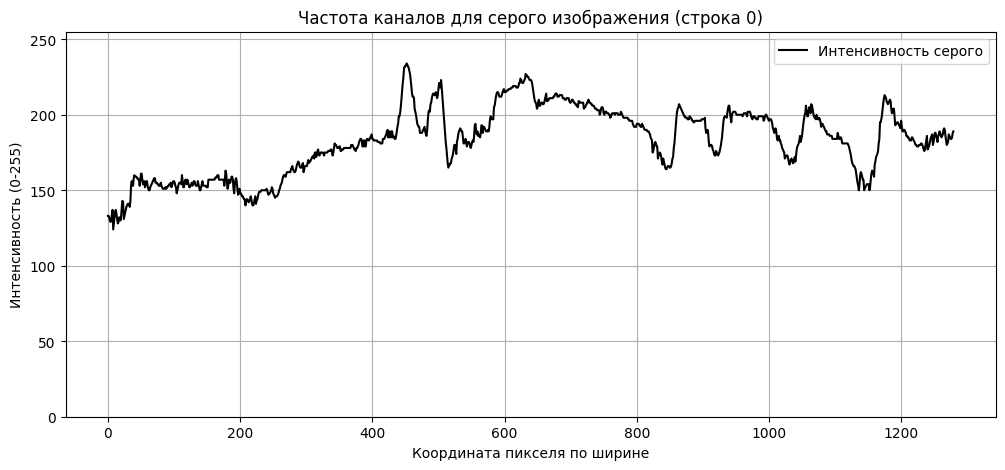


обработка строки: 640


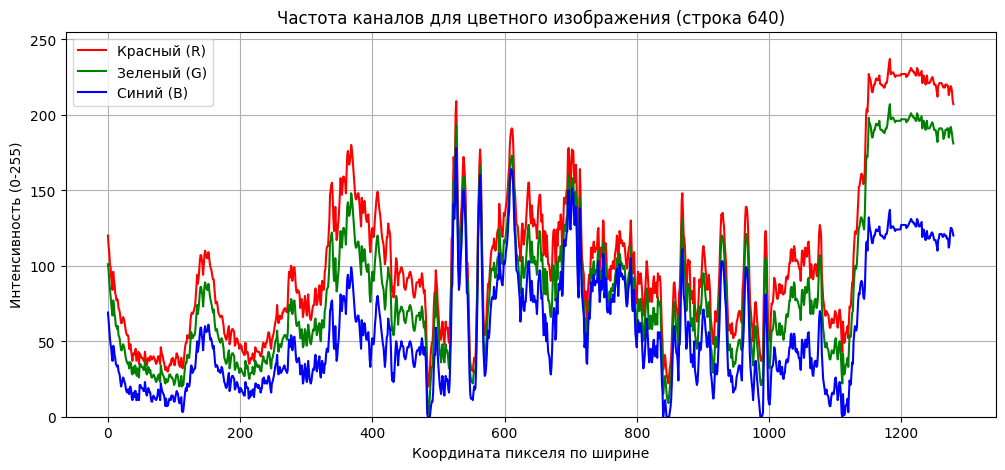

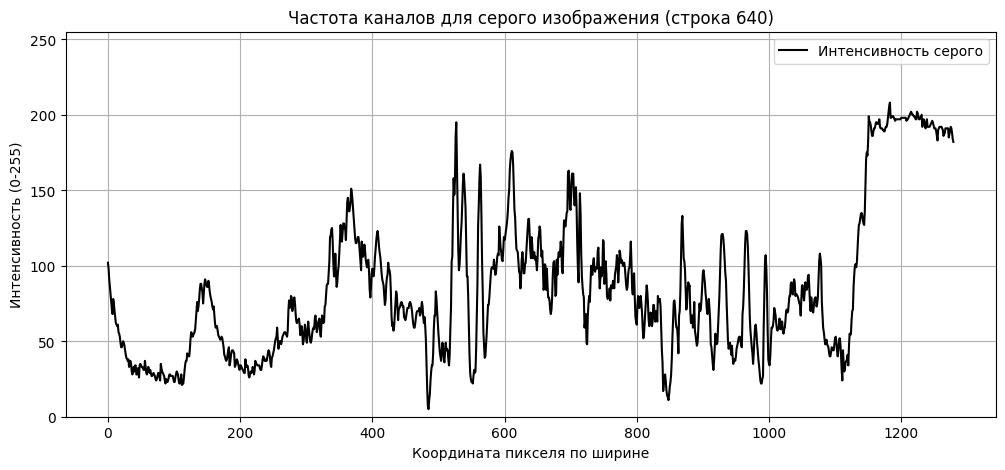


обработка строки: 1279


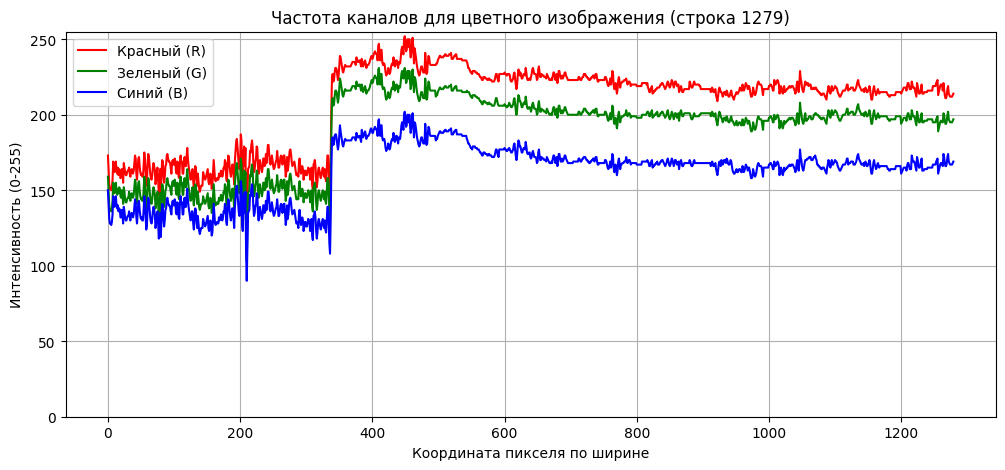

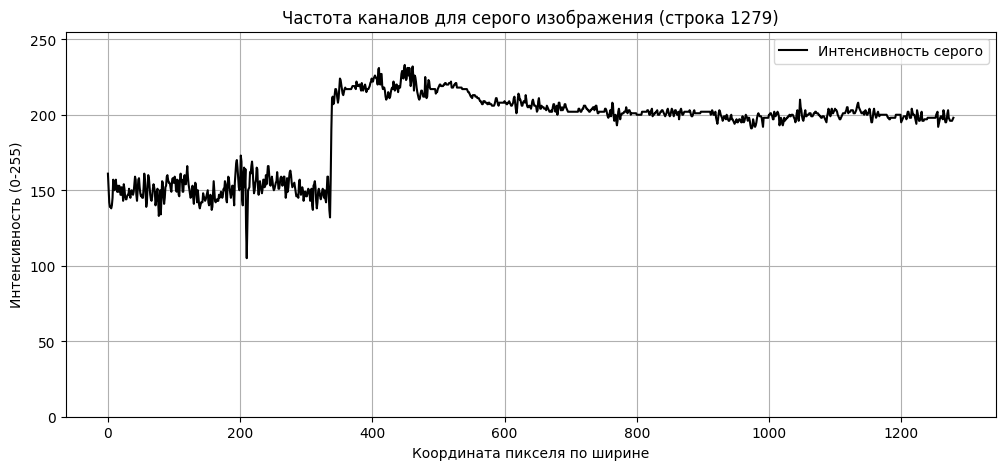

In [ ]:
height, width, _ = orig_im_np.shape

#выбираем строку
row_indices = [0, height // 2, height - 1]

for row_idx in row_indices:
    print(f"\nобработка строки: {row_idx}")

    #данные для цветного изображения
    row_color_data = orig_im_np[row_idx, :, :]
    r_data = row_color_data[:, 0]
    g_data = row_color_data[:, 1]
    b_data = row_color_data[:, 2]

    #данные для серого изображения
    row_gray_data = gray_im_np[row_idx, :]

    #цветное изображение
    plt.figure(figsize=(12, 5))
    plt.plot(r_data, color='red', label='Красный (R)')
    plt.plot(g_data, color='green', label='Зеленый (G)')
    plt.plot(b_data, color='blue', label='Синий (B)')
    plt.title(f'Частота каналов для цветного изображения (строка {row_idx})')
    plt.xlabel('Координата пикселя по ширине')
    plt.ylabel('Интенсивность (0-255)')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 255) #фиксируем яркость
    plt.show()

    #серое изображение
    plt.figure(figsize=(12, 5))
    plt.plot(row_gray_data, color='black', label='Интенсивность серого')
    plt.title(f'Частота каналов для серого изображения (строка {row_idx})')
    plt.xlabel('Координата пикселя по ширине')
    plt.ylabel('Интенсивность (0-255)')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 255)
    plt.show()

##6-7. Реализовать алгоритм свертки изображения с примирением фильтра

In [ ]:
#алгоритм свертки

def convolution(image, kernel):
    kernel_h, kernel_w = kernel.shape
    h, w = image.shape

    #пустое изображение для результата
    output = np.zeros((h, w), dtype=np.uint8)

    #добавляем отступы к изображению, чтобы ядро не выходило за границы
    pad_h = kernel_h // 2
    pad_w = kernel_w // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')

    #применяем свертку
    for y in range(h):
        for x in range(w):
            #вырезаем фрагмент изображения размером с ядро
            region = padded_image[y:y + kernel_h, x:x + kernel_w]
            output[y, x] = np.sum(region * kernel)

    return output

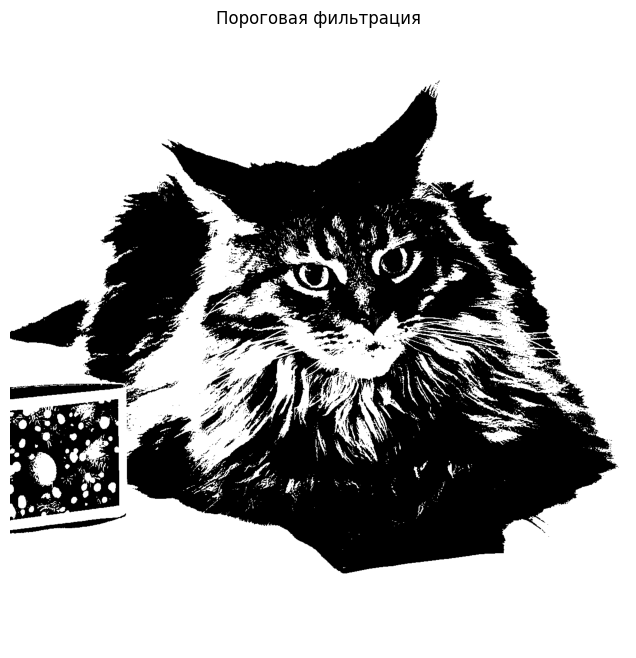

In [ ]:
#(a) Пороговая фильтрация (делает изображение черно-белым)

def threshold_filter(image, threshold):
    result_image = image.copy()
    #если значение пикселя > порога, то 255 (белый), иначе 0 (черный)
    result_image[image > threshold] = 255
    result_image[image <= threshold] = 0
    return result_image

#применяем фильтр
threshold_img = threshold_filter(gray_im_np, threshold=65)

#результат
plt.figure(figsize=(8, 8))
plt.imshow(threshold_img, cmap='gray')
plt.title('Пороговая фильтрация')
plt.axis('off')
plt.show()

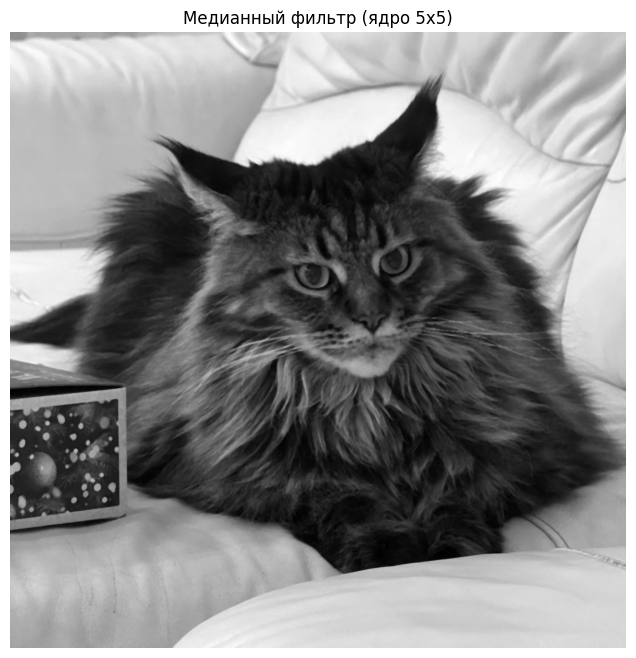

In [ ]:
#(b) Медианный фильтр (хорошо убирает шум)

def median_filter(image, kernel_size):
    h, w = image.shape
    output = np.zeros((h, w), dtype=np.uint8)
    pad_size = kernel_size // 2

    padded_image = np.pad(image, pad_size, mode='edge')

    for y in range(h):
        for x in range(w):
            #вырезаем окрестность
            region = padded_image[y:y + kernel_size, x:x + kernel_size]
            #находим медиану и присваиваем ее центральному пикселю
            output[y, x] = np.median(region)

    return output

#применяем фильтр
median_filtered_img = median_filter(gray_im_np, kernel_size=5)

#результат
plt.figure(figsize=(8, 8))
plt.imshow(median_filtered_img, cmap='gray')
plt.title(f'Медианный фильтр (ядро {5}x{5})')
plt.axis('off')
plt.show()

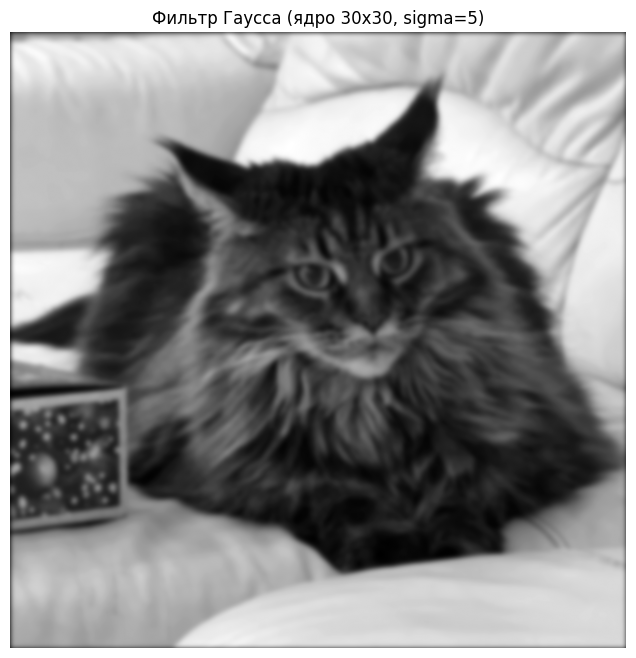

In [ ]:
#(c) Фильтр Гаусса

def gaussian_kernel(size, sigma):
    #cоздаем координатную сетку
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    #cчитаем ядро по формуле Гаусса
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    #нормализуем ядро
    return kernel / np.sum(kernel)

kernel_size_gauss = 30
sigma_gauss = 5

#ядро Гаусса
gauss_k = gaussian_kernel(kernel_size_gauss, sigma_gauss)

#применяем свертку
gaussian_img = convolution(gray_im_np, gauss_k)

#результат
plt.figure(figsize=(8, 8))
plt.imshow(gaussian_img, cmap='gray')
plt.title(f'Фильтр Гаусса (ядро {kernel_size_gauss}x{kernel_size_gauss}, sigma={sigma_gauss})')
plt.axis('off')
plt.show()

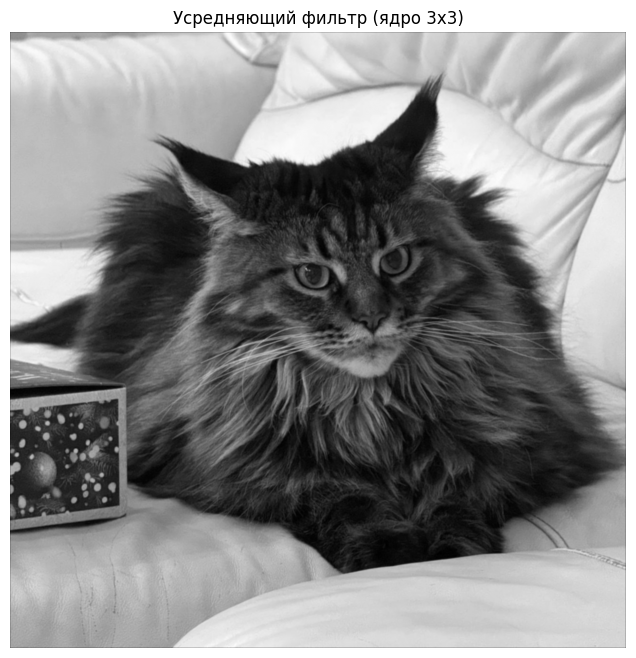

In [ ]:
#(d) Линейный усредняющий фильтр (box blur)

kernel_size_box = 3

#ядро для box blur
box_kernel = np.ones((kernel_size_box, kernel_size_box), dtype=np.uint8) / (kernel_size_box * kernel_size_box)

#применяем свертку
box_blur_img = convolution(gray_im_np, box_kernel)

#результат
plt.figure(figsize=(8, 8))
plt.imshow(box_blur_img, cmap='gray')
plt.title(f'Усредняющий фильтр (ядро {kernel_size_box}x{kernel_size_box})')
plt.axis('off')
plt.show()

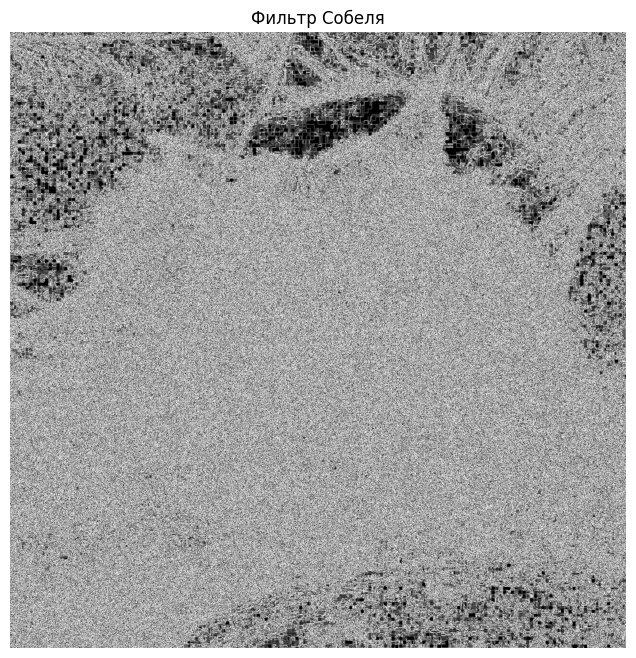

In [ ]:
#(e) Фильтр Собеля

#ядра Собеля
sobel_x_kernel = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.int8)

sobel_y_kernel = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
], dtype=np.int8)

#применяем свертку для каждой оси
grad_x = convolution(gray_im_np, sobel_x_kernel)
grad_y = convolution(gray_im_np, sobel_y_kernel)

#считаем общую величину градиента
sobel_img = np.sqrt(grad_x**2 + grad_y**2)

#нормализуем изображение к диапазону 0-255 для корректного отображения
sobel_img = (sobel_img / np.max(sobel_img)) * 255

#результат
plt.figure(figsize=(8, 8))
plt.imshow(sobel_img, cmap='gray')
plt.title('Фильтр Собеля')
plt.axis('off')
plt.show()

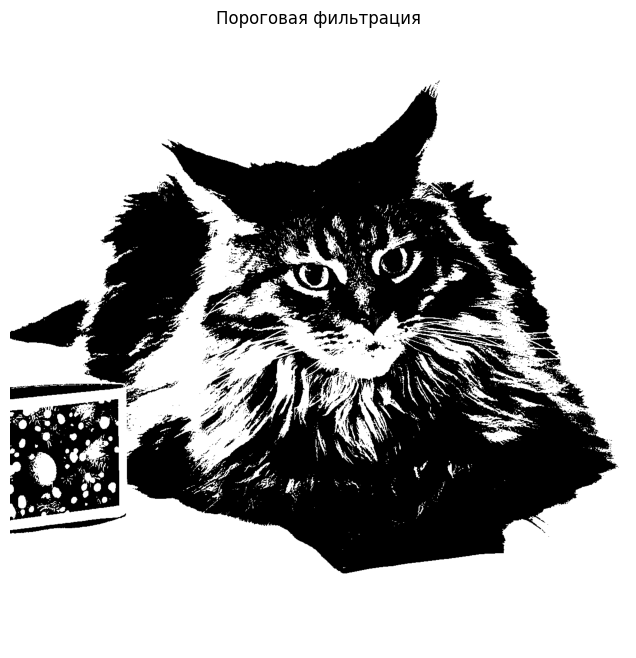

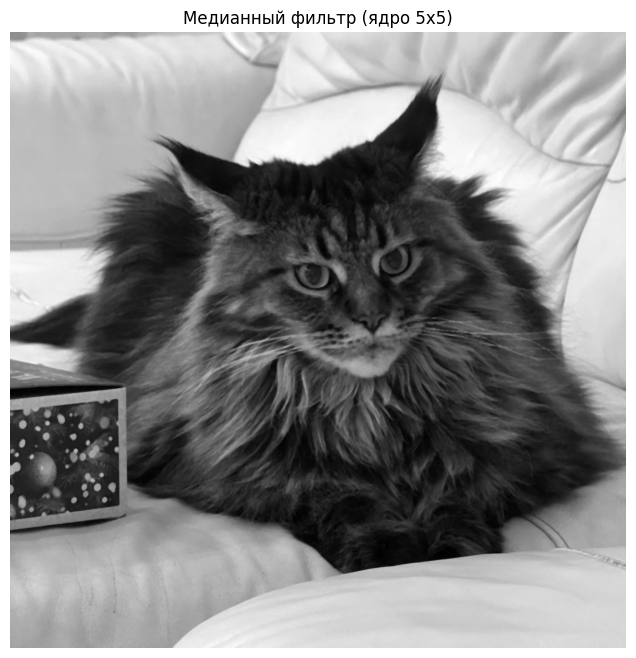

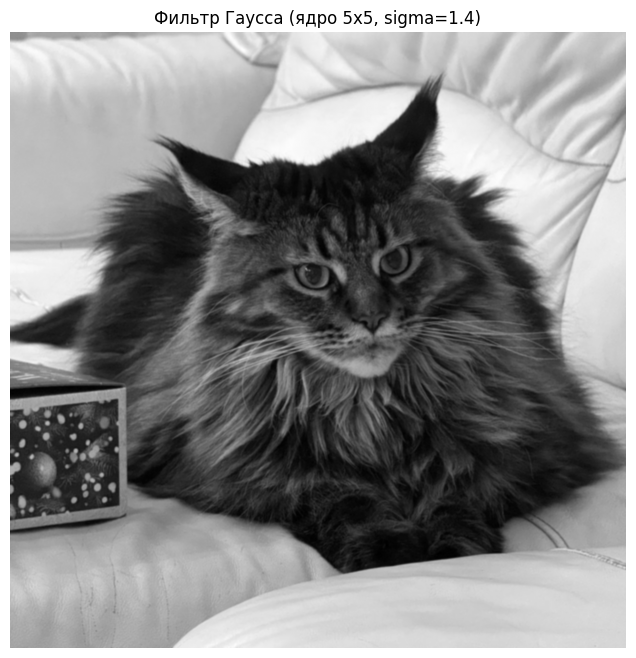

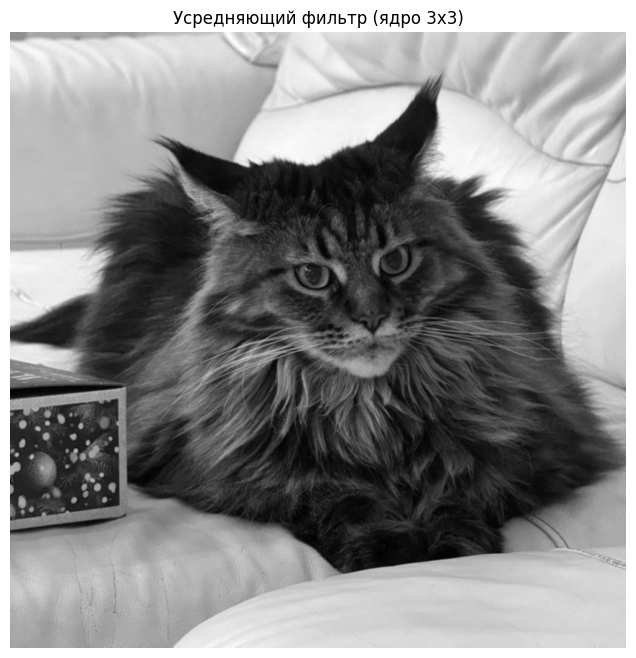

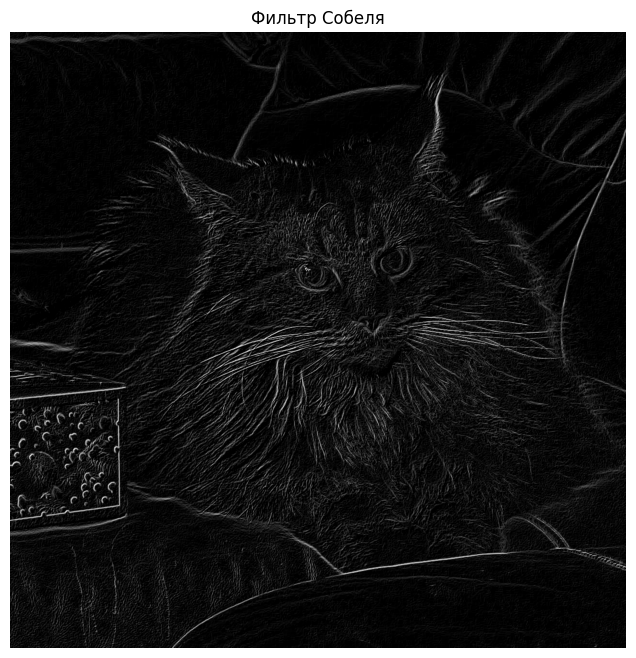

In [ ]:
#я видимо какой-то даун, вот что выдала гпт, до этогго генадий был

# 6-7. Реализация свёртки и фильтров

def convolution(image, kernel):
    """
    g(x,y) = w * f(x,y) = sum_{i=-a..a, j=-b..b} w(i,j) * f(x-i,y-j)
    - на краях используем pad mode='edge' (продление границы)
    image: 2D ndarray uint8 или float32
    kernel: 2D ndarray float32 или float64
    Возвращает 2D ndarray uint8 (после clip)
    """
    kernel_h, kernel_w = kernel.shape
    h, w = image.shape

    # приводим image к float32 для аккуратных расчётов
    img = image.astype(np.float32)
    output = np.zeros((h, w), dtype=np.float32)

    pad_h = kernel_h // 2
    pad_w = kernel_w // 2

    # отражающий отрезок граничных пикселей
    padded_image = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')

    for y in range(h):
        for x in range(w):
            region = padded_image[y:y + kernel_h, x:x + kernel_w]
            output[y, x] = np.sum(region * kernel)

    # приводим к uint8 с отсечением [0,255]
    output_uint8 = np.clip(output, 0, 255).astype(np.uint8)
    return output_uint8


# (a) Пороговая фильтрация
def threshold_filter(image, threshold):
    result_image = image.copy().astype(np.uint8)
    result_image[image > threshold] = 255
    result_image[image <= threshold] = 0
    return result_image

threshold_img = threshold_filter(gray_im_np, threshold=65)
plt.figure(figsize=(8, 8))
plt.imshow(threshold_img, cmap='gray')
plt.title('Пороговая фильтрация')
plt.axis('off')
plt.show()


# (b) Медианный фильтр
def median_filter(image, kernel_size):
    h, w = image.shape
    output = np.zeros((h, w), dtype=np.uint8)
    pad_size = kernel_size // 2

    # продление границ «по краю»
    padded_image = np.pad(image, pad_size, mode='edge')

    for y in range(h):
        for x in range(w):
            region = padded_image[y:y + kernel_size, x:x + kernel_size]
            output[y, x] = np.median(region)

    return output

median_filtered_img = median_filter(gray_im_np, kernel_size=5)
plt.figure(figsize=(8, 8))
plt.imshow(median_filtered_img, cmap='gray')
plt.title(f'Медианный фильтр (ядро {5}x{5})')
plt.axis('off')
plt.show()


# (c) Фильтр Гаусса
def gaussian_kernel(size, sigma):
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

kernel_size_gauss = 5
sigma_gauss = 1.4
gauss_k = gaussian_kernel(kernel_size_gauss, sigma_gauss)

gaussian_img = convolution(gray_im_np, gauss_k)
plt.figure(figsize=(8, 8))
plt.imshow(gaussian_img, cmap='gray')
plt.title(f'Фильтр Гаусса (ядро {kernel_size_gauss}x{kernel_size_gauss}, sigma={sigma_gauss})')
plt.axis('off')
plt.show()


# (d) Линейный усредняющий фильтр (box blur)
kernel_size_box = 3
box_kernel = np.ones((kernel_size_box, kernel_size_box), dtype=np.float32) / (kernel_size_box * kernel_size_box)

box_blur_img = convolution(gray_im_np, box_kernel)
plt.figure(figsize=(8, 8))
plt.imshow(box_blur_img, cmap='gray')
plt.title(f'Усредняющий фильтр (ядро {kernel_size_box}x{kernel_size_box})')
plt.axis('off')
plt.show()


# (e) Фильтр Собеля
sobel_x_kernel = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float32)

sobel_y_kernel = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
], dtype=np.float32)

grad_x = convolution(gray_im_np, sobel_x_kernel).astype(np.float32)
grad_y = convolution(gray_im_np, sobel_y_kernel).astype(np.float32)

sobel_magnitude = np.sqrt(grad_x**2 + grad_y**2)
# нормируем magnitude в диапазон [0,255]
sobel_img = np.clip((sobel_magnitude / np.max(sobel_magnitude)) * 255, 0, 255).astype(np.uint8)

plt.figure(figsize=(8, 8))
plt.imshow(sobel_img, cmap='gray')
plt.title('Фильтр Собеля')
plt.axis('off')
plt.show()


In [ ]:
def fourier_upscale_manual_corrected(gray_image, scale_factor, m_coeffs_limit=None, n_coeffs_limit=None):
    if not isinstance(gray_image, np.ndarray) or gray_image.ndim != 2:
        raise ValueError("Входное изображение должно быть 2D NumPy массивом (градации серого).")

    # 1. Нормализация изображения
    f_xy_orig = gray_image.astype(np.float32) / 255.0
    l2_orig, l1_orig = f_xy_orig.shape  # высота, ширина

    # 2. Установка пределов для коэффициентов Фурье
    if m_coeffs_limit is None:
        m_coeffs_limit = l1_orig // 2
    if n_coeffs_limit is None:
        n_coeffs_limit = l2_orig // 2

    print(f"Исходные размеры: {l1_orig}x{l2_orig}")
    print(f"Пределы коэффициентов: m={m_coeffs_limit}, n={n_coeffs_limit}")

    # 3. Расчет коэффициентов Фурье a_jk
    y_coords_orig, x_coords_orig = np.mgrid[0:l2_orig, 0:l1_orig]
    a_coeffs = np.zeros((2 * n_coeffs_limit + 1, 2 * m_coeffs_limit + 1), dtype=np.float32)

    print("Расчет коэффициентов a_jk...")
    for k_idx, k_freq in enumerate(tqdm(range(-n_coeffs_limit, n_coeffs_limit + 1), desc="k_freq")):
        for j_idx, j_freq in enumerate(range(-m_coeffs_limit, m_coeffs_limit + 1)):
            # Косинусные составляющие
            term_x = np.cos(np.pi * j_freq * x_coords_orig / l1_orig)
            term_y = np.cos(np.pi * k_freq * y_coords_orig / l2_orig)

            # Интегрирование
            integrand = f_xy_orig * term_x * term_y
            a_jk = np.sum(integrand) / (l1_orig * l2_orig)
            a_coeffs[k_idx, j_idx] = a_jk

    # 4. Реконструкция увеличенного изображения
    l1_new = int(round(l1_orig * scale_factor))
    l2_new = int(round(l2_orig * scale_factor))
    print(f"Новые размеры: {l1_new}x{l2_new}")

    # Координатные сетки для нового изображения
    y_coords_new, x_coords_new = np.mgrid[0:l2_new, 0:l1_new]
    reconstructed = np.zeros((l2_new, l1_new), dtype=np.float32)

    # Знаменатели для нормализации координат
    denom_x = l1_orig * scale_factor
    denom_y = l2_orig * scale_factor

    print("Реконструкция изображения...")
    for k_idx, k_freq in enumerate(tqdm(range(-n_coeffs_limit, n_coeffs_limit + 1), desc="Реконструкция")):
        for j_idx, j_freq in enumerate(range(-m_coeffs_limit, m_coeffs_limit + 1)):
            a_jk = a_coeffs[k_idx, j_idx]

            # Косинусные составляющие для новых координат
            term_x = np.cos(np.pi * j_freq * x_coords_new / denom_x)
            term_y = np.cos(np.pi * k_freq * y_coords_new / denom_y)

            reconstructed += a_jk * term_x * term_y

    # 5. Денормализация и преобразование в uint8
    upscaled = np.clip(reconstructed * 255.0, 0, 255).astype(np.uint8)
    return upscaled

In [ ]:
scale = 2  # Коэффициент увеличения
demo_size = 100  # Ширина уменьшенного изображения

In [ ]:
if orig_im_np.ndim == 3:
    gray_full = cv2.cvtColor(orig_im_np, cv2.COLOR_RGB2GRAY)
else:
    gray_full = orig_im_np

# Уменьшение изображения для демонстрации
height, width = gray_full.shape
demo_h = int(height * demo_size / width)

if width > demo_size:
    print(f"Уменьшаем изображение до {demo_size}x{demo_h}")
    small = cv2.resize(gray_full, (demo_size, demo_h), interpolation=cv2.INTER_AREA)
else:
    small = gray_full.copy()

# Параметры коэффициентов Фурье
# m_limit = small.shape[1] // 2
# n_limit = small.shape[0] // 2

# m_limit = min(small.shape[1] // 2, 80)
# n_limit = min(small.shape[0] // 2, 80)
# m_limit = max(small.shape[1] // 2, 80)
# n_limit = max(small.shape[0] // 2, 80)
# m_limit = max(small.shape[1] // 2, 120)
# n_limit = max(small.shape[0] // 2, 120)
# m_limit = max(small.shape[1] // 2, 100)
# n_limit = max(small.shape[0] // 2, 100)
# m_limit = small.shape[1]
# n_limit = small.shape[0]
# я устал это перебирать, чтобы оно действительно было красивым, оставлю так

m_limit = max(small.shape[1] // 2, 80)
n_limit = max(small.shape[0] // 2, 80)
print(f"Используемые пределы: m={m_limit}, n={n_limit}")

Уменьшаем изображение до 100x100
Используемые пределы: m=80, n=80


In [ ]:
upscaled_fourier = fourier_upscale_manual_corrected(
    small,
    scale_factor=scale,
    m_coeffs_limit=m_limit,
    n_coeffs_limit=n_limit
)

# Билинейный апскейл для сравнения
upscaled_bilinear = cv2.resize(
    small,
    (small.shape[1] * scale, small.shape[0] * scale),
    interpolation=cv2.INTER_LINEAR
)


Исходные размеры: 100x100
Пределы коэффициентов: m=80, n=80
Расчет коэффициентов a_jk...


k_freq: 100%|██████████| 161/161 [00:14<00:00, 11.20it/s]


Новые размеры: 200x200
Реконструкция изображения...


Реконструкция: 100%|██████████| 161/161 [00:53<00:00,  2.99it/s]


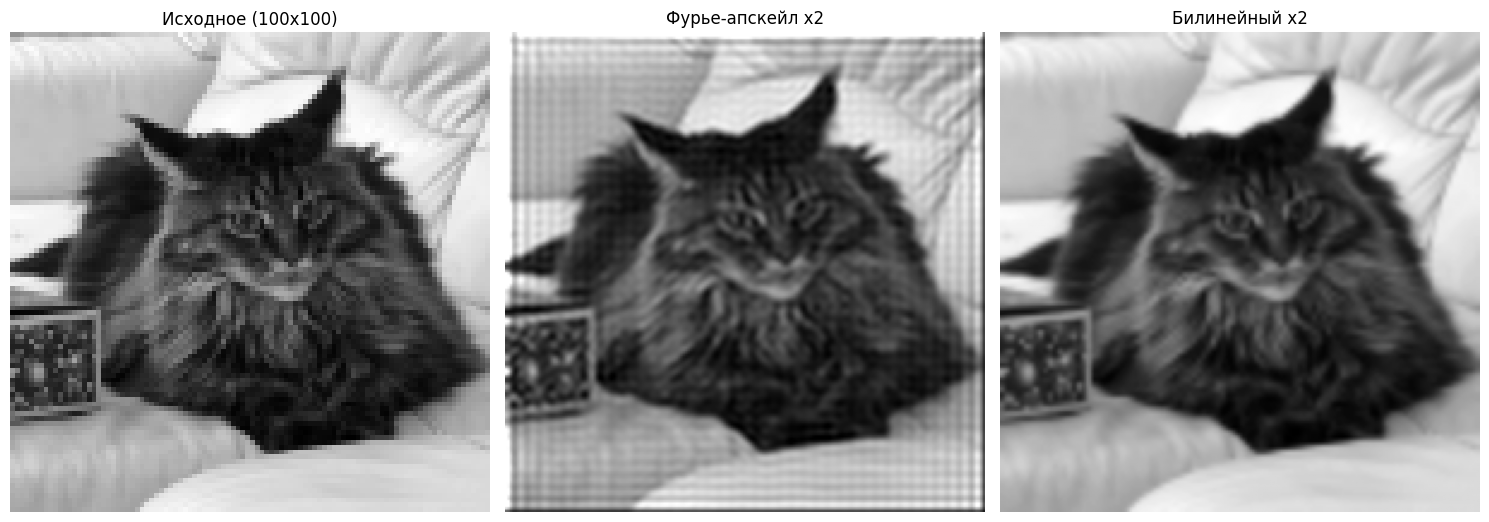

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(131)
plt.imshow(small, cmap='gray')
plt.title(f'Исходное ({small.shape[1]}x{small.shape[0]})')
plt.axis('off')

plt.subplot(132)
plt.imshow(upscaled_fourier, cmap='gray')
plt.title(f'Фурье-апскейл x{scale}')
plt.axis('off')

plt.subplot(133)
plt.imshow(upscaled_bilinear, cmap='gray')
plt.title(f'Билинейный x{scale}')
plt.axis('off')

plt.tight_layout()
plt.show()

##9. Изобразите фурье-спектр изображения. Попробуйте применить различные преобразования к полученному фурье-спектру.

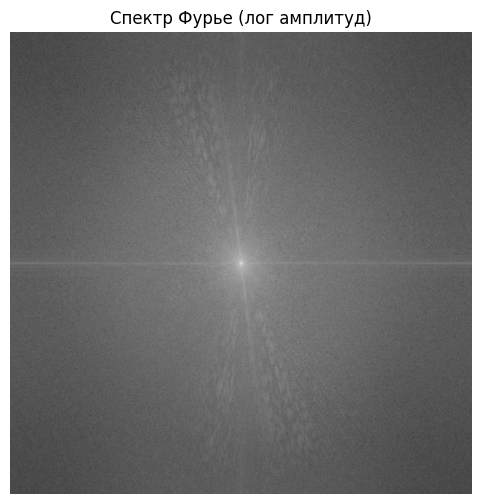

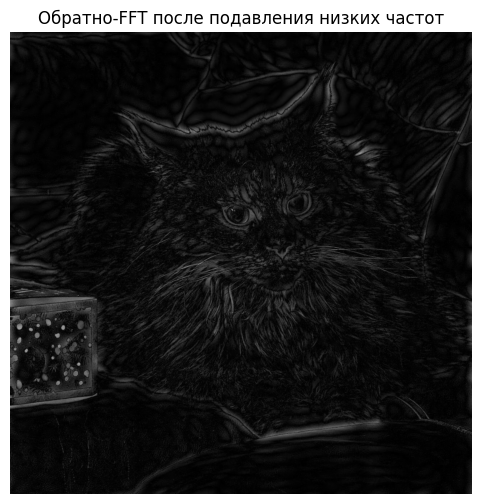

In [ ]:
f = np.fft.fft2(gray_im_np)
fshift = np.fft.fftshift(f)
# Модуль спектра
magnitude_spectrum = 20*np.log(np.abs(fshift) + 1)

plt.figure(figsize=(6,6))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Спектр Фурье (лог амплитуд)')
plt.axis('off')
plt.show()

# Пример фильтрации в частотной области: подавление низких частот (high-pass)
rows, cols = gray_im_np.shape
crow, ccol = rows//2, cols//2
# Создадим копию спектра и обнулим центральные низкочастотные компоненты
fshift_hp = fshift.copy()
cutoff = 20  # радиус вырезания низких частот
fshift_hp[crow-cutoff:crow+cutoff, ccol-cutoff:ccol+cutoff] = 0

# Обратное преобразование Фурье
f_ishift = np.fft.ifftshift(fshift_hp)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

plt.figure(figsize=(6,6))
plt.imshow(img_back, cmap='gray')
plt.title('Обратно-FFT после подавления низких частот')
plt.axis('off')
plt.show()

##10. Реализовать высокочастотную и низкочастотную фильтрацию изображения. Путем удаления низкочастотной составляющей, получить изображение с повышенной резкостью, которое содержит края.

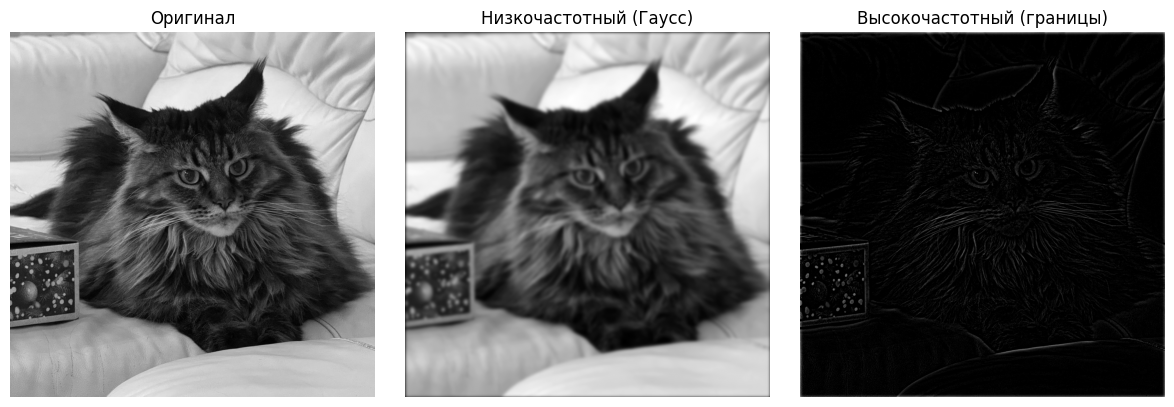

In [ ]:
low_pass = cv2.subtract(gray_im_np.astype(int), gaussian_img.astype(int))
high_pass = np.clip(low_pass, 0, 255).astype(np.uint8)
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(gray_im_np,cmap='gray'); ax[0].set_title('Оригинал'); ax[0].axis('off')
ax[1].imshow(gaussian_img,cmap='gray'); ax[1].set_title('Низкочастотный (Гаусс)'); ax[1].axis('off')
ax[2].imshow(high_pass,cmap='gray'); ax[2].set_title('Высокочастотный (границы)'); ax[2].axis('off')
plt.tight_layout()
plt.show()